#Software Engineer - risk test

#Stop credit card fraud: Implement the concept of a simple anti-fraud

This notebook explores different features of a bank fraud dataset. In particular, a sample from the [Stop credit card fraud](https://gist.githubusercontent.com/cloudwalk-tests/76993838e65d7e0f988f40f1b1909c97/raw/9ceae962009236d3570f46e59ce9aa334e4e290f/transactional-sample.csv), which is a dataset containing a month's worth of credit card transactions in a rather raw state. It also indicates whether the transaction has been identified as a chargeback (a type of fraud) or not.

##Installing and Importing Libraries

In [32]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


from IPython.display            import Markdown

Setting the specifications for the charts

In [33]:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

Setting the data dicionary

In [34]:
df_dicionary = {
    'transaction_id': 'Transaction ID.',
    'merchant_id': 'Merchant ID.',
    'user_id': 'User ID.',
    'card_number': 'Card Number.',
    'transaction_date': 'Exactly the moment of the transaction.',
    'transaction_amount': 'Amount of the transaction.',
    'device_id': 'Device ID used in the transaction.',
    'has_cbk': 'Confirmation if a chargeback was initiated.'
}

##Setting the auxiliar functions

In [35]:

#function to create a missing data report
def generate_missing_report(df):
    missing_count = df.isna().sum()

   
    missing_pct = (df.isna().sum() / df.shape[0])

   
    df_missing = (
        missing_count.to_frame('missing_count')
        .join(missing_pct.to_frame('missing_pct'))
        .sort_values('missing_count', ascending=False)
    )

    
    df_missing['missing_pct'] = df_missing['missing_pct'].map('{:.2%}'.format)

    return df_missing

#function used to describe the data
def describe_data_types(df):

    data_types = df.dtypes
    data_types_description = pd.DataFrame(data_types, columns=['Data Type'])
    data_types_description['Unique Values'] = df.nunique()

    return data_types_description


#Setting a function to understand the data caracteristics

def col_understand_only_numbers(df, col_dict):
    for column, data_column in col_dict.items():
        is_whole_number = df[data_column].apply(lambda x: str(x).isdigit())
        all_whole_numbers = is_whole_number.all()

        # Print the result for each column
        print(f"Does '{column}' column contain only numbers? {all_whole_numbers}")

#Custom function to identify outliers in an array
def is_outlier(array, extreme=False):
  
  q1,q3 = np.quantile(array, [.25,.75])
  iqr = q3-q1

  factor = 3. if extreme else 1.5
  upper_outlier = q3 + factor*iqr
  lower_outlier = q1 - factor*iqr

  return (array < lower_outlier) | (array > upper_outlier)


#chargeback auxiliar function for description:

def chargeback_description(df, columns):
    chargeback_counts_df = pd.DataFrame(columns=['Column', 'Chargeback_Count'])
    chargeback_df = df[df['has_cbk']]

    for col in columns:
        chargeback_counts = chargeback_df[col].value_counts().head(10)
        temp_df = pd.DataFrame({'Column': chargeback_counts.index, 'Chargeback_Count': chargeback_counts.values})
        chargeback_counts_df = pd.concat([chargeback_counts_df, temp_df])

    chargeback_counts_df = chargeback_counts_df.sort_values(by='Chargeback_Count', ascending=True)

    chargeback_counts_df.reset_index(drop=True, inplace=True)
    return chargeback_counts_df

#function to make a data enrichment in time dtypes

def dt_engineering(df):
    df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')

    df["year"] = df['transaction_date'].dt.year
    df["month"] = df['transaction_date'].dt.month
    df["day"] = df['transaction_date'].dt.day
    df["hour"] = df['transaction_date'].dt.hour
    df["min"] = df['transaction_date'].dt.minute
    df['sec'] = df['transaction_date'].dt.second

    return df

#function to create a client profile
def client_outline(df):
    user_device_count = df.groupby('user_id')['device_id'].nunique().reset_index()
    user_device_count.columns = ['user_id', 'device_count']
    cbk_true_df = df[df['has_cbk'] == True]
    result_df = pd.merge(user_device_count, cbk_true_df, on='user_id', how='left').fillna(0)
    
    # Calculate device_category within the function
    result_df['device_category'] = pd.cut(result_df['device_count'],
                                      bins=[0, 1, 2, 3, 4, float('inf')],
                                      labels=['1 device', '2 devices', '3 devices', '4 devices', '5 devices or more'])

    category_summary = result_df.groupby('device_category').agg({'user_id': 'count', 'has_cbk': 'sum'}).reset_index()
    category_summary.columns = ['device_category', 'user_count', 'cbk_true_count']

    return category_summary

#business model rules
def apply_business_rules(df):
    # Existing rules
    df['score_in_transaction_amount'] = np.where(df['transaction_amount'] > 2000, 120, 271)
    df['score_hour'] = np.where(df['hour'] > 12, 316, 75)
    df['score_merchant'] = df.groupby('merchant_id')['transaction_amount'].transform(lambda x: (x.sum() * 0.05) if x.any() else 0)
    df['score_user'] = df.groupby('user_id')['transaction_amount'].transform(lambda x: (x.sum() * 0.1) if x.any() else 0)
    if 'device_category' in df.columns:
        score_mapping = {'1 device': 258, '2 devices': 36, '3 devices': 5, '4 devices': 25, '5 devices or more': 0}
        df['score_device_category'] = df['device_category'].map(score_mapping).fillna(0)
    else:
        df['score_device_category'] = 0

    # Calculate total score
    df['score_in_device_id'] = np.where(df['device_id'].isna(), 67, 0)
    df['total_score'] = df['score_in_transaction_amount'] + df['score_hour'] + df['score_in_device_id'] + df['score_merchant'] + df['score_user'] + df['score_device_category']

    return df

# function that receive all users_id fraudulents and transform in a list
def filter_fraudulent_transactions(df):
    fraud_df = pd.read_csv(r'C:\Users\nando\OneDrive\Área de Trabalho\CLOUDWALK_API\frauds.csv')
    fraud_ids = fraud_df[fraud_df['has_cbk'] == True]['user_id'].unique().tolist()
    return fraud_ids

#function that create a new colum 'status' and give the value 'denied' or 'approved'
def status_update(df, fraudulent_users):
    df['status'] = 'approved'

    fraud_ids = filter_fraudulent_transactions(df)
    df.loc[df['user_id'].isin(fraud_ids), 'status'] = 'denied'
    df.loc[df['total_score'] > 1250, 'status'] = 'denied'
    return df


def filter_per_transaction_amount(df):
    filter_1 = (df['has_cbk'] == True) & (df['transaction_amount'] < 2000)
    big_transactions = df[filter_1].shape[0]


    filter_2 = (df['has_cbk'] == True) & (df['transaction_amount'] >= 2000)
    small_transactions = df[filter_2].shape[0]


    resultado = pd.DataFrame({
        'Quantidade_CBK_Abaixo_2000': [big_transactions],
        'Quantidade_CBK_Acima_2000': [small_transactions]
    })

    return resultado

def generate_user_cbk_counts(df):
    
    user_cbk_counts = df.groupby('user_id')['has_cbk'].value_counts().unstack(fill_value=0)

    user_cbk_counts['has_cbk_true_sum'] = user_cbk_counts[True]
    user_cbk_counts['has_cbk_false_sum'] = user_cbk_counts[False]

    user_cbk_counts['total_transactions'] = df['user_id'].value_counts().sort_index()

    user_cbk_counts = user_cbk_counts[['has_cbk_true_sum', 'has_cbk_false_sum', 'total_transactions']]

    user_cbk_counts.reset_index(inplace=True)

    user_cbk_counts.sort_values(by='has_cbk_true_sum', ascending=False, inplace=True)

    return user_cbk_counts

##Dataset

Data Dictionary

- **transaction_id: 0:** Transaction ID.
- **merchant_id:** Merchant ID.
- **user_id	:** User ID.
- **card_number:** Card Number.
- **transaction_date:** Exatly the moment of the transaction.
- **transaction_amount:** Amount of the transaction.
- **device_id:** Device ID used in the transaction.
- **has_cbk:** Confirmation if a chargeback was initiated.

In [36]:
df = pd.read_csv(r'C:\Users\nando\OneDrive\Documentos\GitHub\Anti_Fraud_model\frauds.csv')

In [37]:
df.head()

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk
0,21320398,29744,97051,434505******9116,2019-12-01T23:16:32.812632,374.56,285475.0,False
1,21320399,92895,2708,444456******4210,2019-12-01T22:45:37.873639,734.87,497105.0,True
2,21320400,47759,14777,425850******7024,2019-12-01T22:22:43.021495,760.36,NaN,False
3,21320401,68657,69758,464296******3991,2019-12-01T21:59:19.797129,2556.13,NaN,True
4,21320402,54075,64367,650487******6116,2019-12-01T21:30:53.347051,55.36,860232.0,False


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_id      3199 non-null   int64  
 1   merchant_id         3199 non-null   int64  
 2   user_id             3199 non-null   int64  
 3   card_number         3199 non-null   object 
 4   transaction_date    3199 non-null   object 
 5   transaction_amount  3199 non-null   float64
 6   device_id           2369 non-null   float64
 7   has_cbk             3199 non-null   bool   
dtypes: bool(1), float64(2), int64(3), object(2)
memory usage: 178.2+ KB


##Pre-Processing

###Examination of Data Coherence and Integrity

In [39]:
#describing missing values
generate_missing_report(df)

,missing_count,missing_pct
device_id,830,25.95%
transaction_id,0,0.00%
merchant_id,0,0.00%
user_id,0,0.00%
card_number,0,0.00%
transaction_date,0,0.00%
transaction_amount,0,0.00%
has_cbk,0,0.00%


###Null values:
</p>
For the null treatment you have 3 strategies: </p>
- Communicate with the project sponsor and attempt to recover the missing values.</p>
- Drop null values </p>
- Imputing values </p>

In this project, I chose to split the data into two dataframes: df (without null values) and nan_data (df with all null values). I made this choice because I wasn't sure if these NaN values had any analytical value. </p>

**NOTE: ** Since the NaN values are in the "device_id," which is one of the ID columns (primary key) for another df is advisable not to use it in future analyses.

In [40]:
#setting another dataframe with the columns with nan values
nan_data = df[df.isna().any(axis=1)]

#setting the dataframe for analysis without nan values
df = df[~df.index.isin(nan_data.index)]

### Duplicated Values:
</p>



The Dataframe has no duplicated values

In [41]:
df[df.duplicated(keep=False)]

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk


### Outliers:
</p>



(array([1]), [Text(1, 0, 'transaction_amount')])

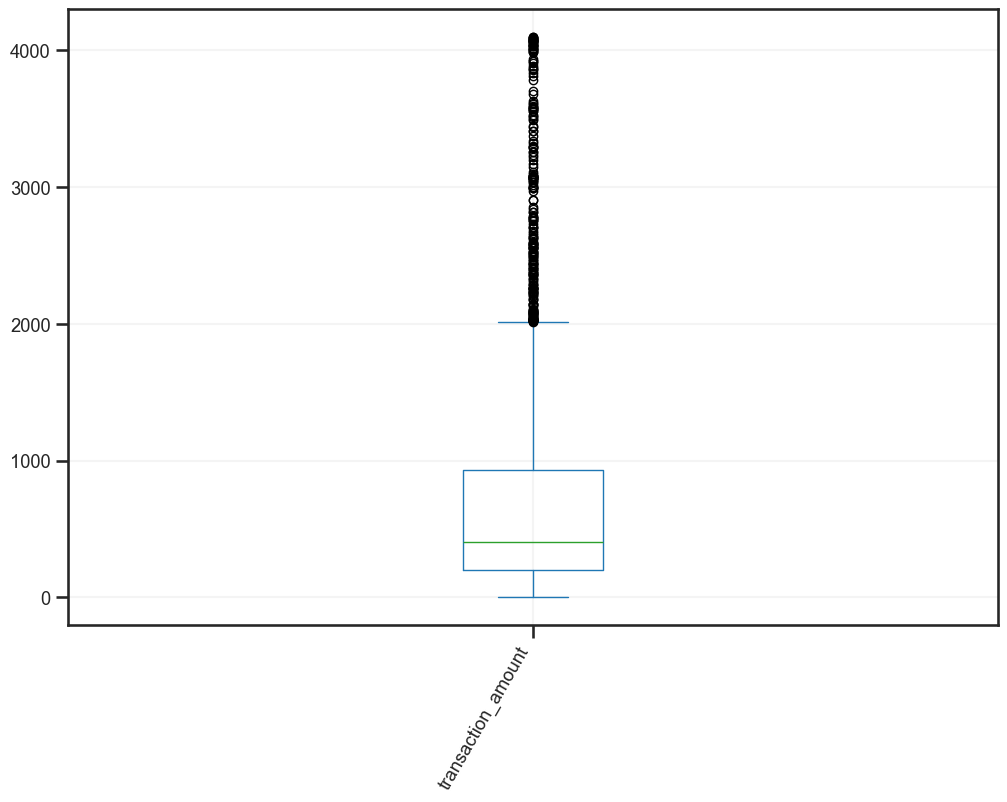

In [42]:
df['transaction_amount'].plot.box()
plt.xticks(rotation=60, ha='right')

In [43]:
df['transaction_amount'].apply(is_outlier).sum()

0

### Changing Data Types:
</p>


In [44]:
#method to imput the transaction_amount and extract more features
dt_engineering(df)

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk,year,month,day,hour,min,sec
0,21320398,29744,97051,434505******9116,2019-12-01 23:16:32.812632,374.56,285475.0,False,2019,12,1,23,16,32
1,21320399,92895,2708,444456******4210,2019-12-01 22:45:37.873639,734.87,497105.0,True,2019,12,1,22,45,37
4,21320402,54075,64367,650487******6116,2019-12-01 21:30:53.347051,55.36,860232.0,False,2019,12,1,21,30,53
5,21320403,59566,40759,516292******8220,2019-12-01 21:25:53.374213,60.49,192705.0,False,2019,12,1,21,25,53
6,21320404,20917,25661,650485******9310,2019-12-01 21:25:19.532243,318.37,760932.0,False,2019,12,1,21,25,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756,21323154,17348,57594,406168******4222,2019-11-11 23:14:56.480571,2771.39,645413.0,False,2019,11,11,23,14,56
2763,21323161,95558,44280,650491******3107,2019-11-11 21:24:34.346913,151.21,743254.0,False,2019,11,11,21,24,34
2846,21323244,26765,84730,527497******8763,2019-11-10 16:15:05.469610,561.34,723309.0,False,2019,11,10,16,15,5
2866,21323264,91972,24644,464297******6840,2019-11-10 01:37:02.447645,136.27,977260.0,False,2019,11,10,1,37,2


Structure to understand if the colum has mixed values or not.<p>
I use this to choose what kind of datatype I will setup


In [45]:
#Function accept a dictionary as input for a function to determine if it contains only numbers or a mix of values
col_dict = {'merchant_id': 'merchant_id',  'user_id': 'user_id', 'transaction_id': 'transaction_id', 'device_id': 'device_id' }
col_understand_only_numbers(df, col_dict)

Does 'merchant_id' column contain only numbers? True
Does 'user_id' column contain only numbers? True
Does 'transaction_id' column contain only numbers? True
Does 'device_id' column contain only numbers? False


In [46]:
#coverting columns to string type
cols_to_category = ['transaction_id', 'merchant_id', 'user_id', 'card_number']
df[cols_to_category] = df[cols_to_category].astype(str)


##Business Understanding

##Data Composition

In [47]:
#setting numerical columns:
num_cols = df[[ 'transaction_amount', 'year', 'month', 'day', 'hour', 'min', 'sec']]

#setting category columns:
cat_cols = df[['merchant_id', 'user_id', 'card_number', 'has_cbk', 'transaction_id', 'device_id']]


### Describing the Category Data

In [48]:
describe_data_types(df)

,Data Type,Unique Values
transaction_id,object,2369
merchant_id,object,1419
user_id,object,1968
card_number,object,2176
transaction_date,datetime64[ns],2369
transaction_amount,float64,2323
device_id,float64,1996
has_cbk,bool,2
year,int32,1
month,int32,2


Text(0.5, 1.0, 'Top 10 Merchants with more Chargeback Complaints')

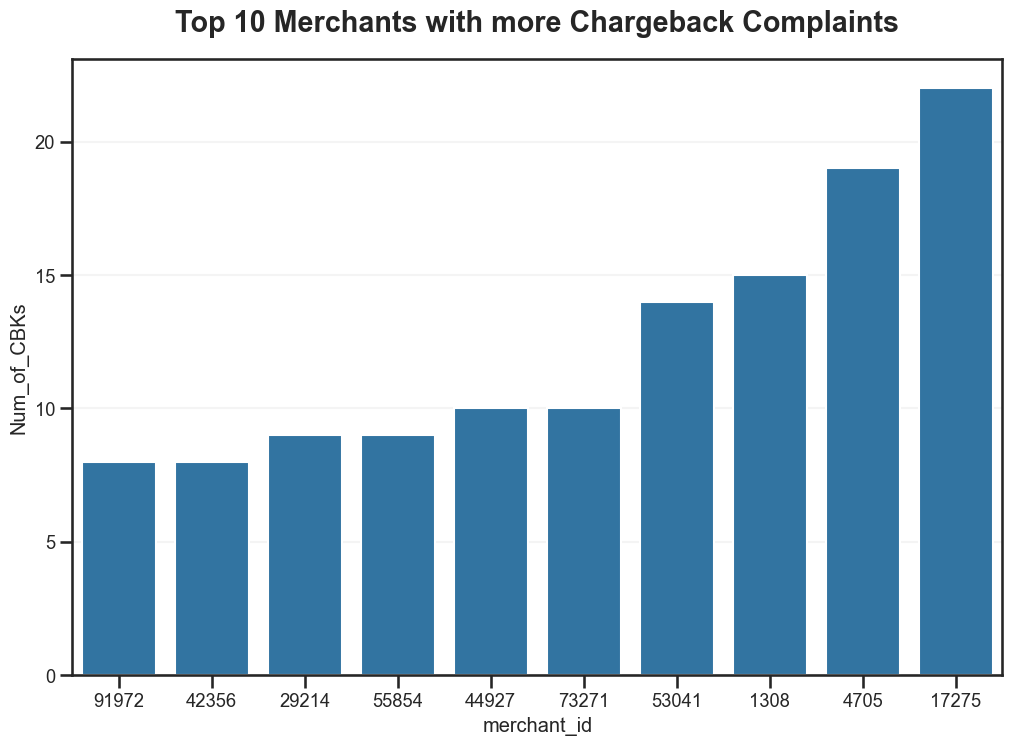

In [49]:
chosen_columns = ['merchant_id']
result_df = chargeback_description(df, chosen_columns)

result_df.rename(columns={'Column': 'merchant_id'}, inplace=True)
result_df.rename(columns={'Chargeback_Count': 'Num_of_CBKs'}, inplace=True)

sns.barplot(x='merchant_id', y='Num_of_CBKs', data=result_df, order=result_df['merchant_id'])
plt.title('Top 10 Merchants with more Chargeback Complaints')

Text(0.5, 1.0, 'Top 10 Users with more Chargeback Complaints')

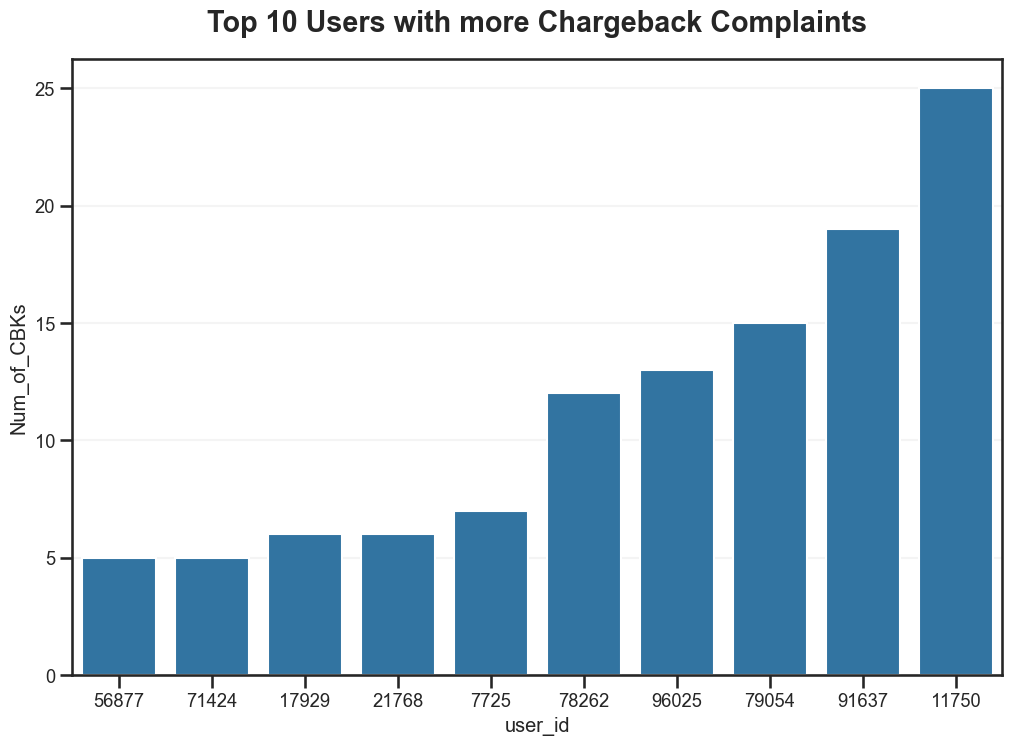

In [50]:
chosen_columns = ['user_id']
result_df = chargeback_description(df, chosen_columns)

result_df.rename(columns={'Column': 'user_id'}, inplace=True)
result_df.rename(columns={'Chargeback_Count': 'Num_of_CBKs'}, inplace=True)

sns.barplot(x='user_id', y='Num_of_CBKs', data=result_df, order=result_df['user_id'])
plt.title('Top 10 Users with more Chargeback Complaints')

C:\Users\nando\AppData\Local\Temp\ipykernel_4516\2053407575.py:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  chargeback_counts_df = pd.concat([chargeback_counts_df, temp_df])


Text(0.5, 1.0, 'Top 10 Devices with more Chargeback Complaints')

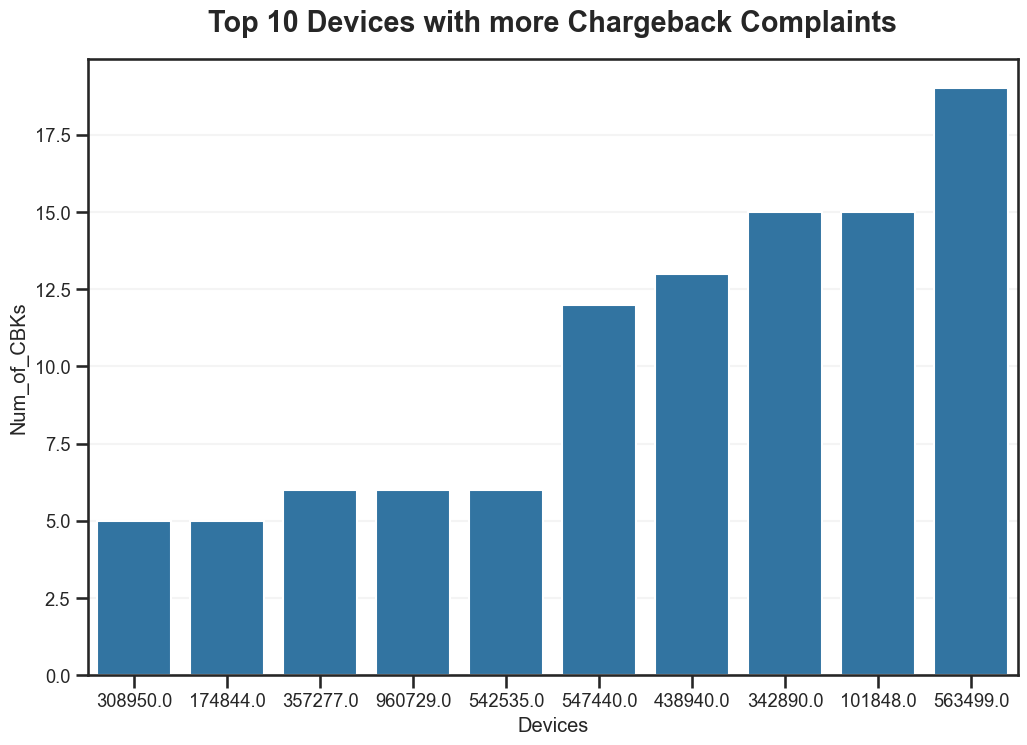

In [51]:
chosen_columns = ['device_id']
result_df = chargeback_description(df, chosen_columns)

result_df.rename(columns={'Column': 'Devices'}, inplace=True)
result_df.rename(columns={'Chargeback_Count': 'Num_of_CBKs'}, inplace=True)

sns.barplot(x='Devices', y='Num_of_CBKs', data=result_df, order=result_df['Devices'])
plt.title('Top 10 Devices with more Chargeback Complaints')

###CHARGEBACK PROFILES

Conclusion: Beyond the $2000.00 threshold, there is a significantly increased susceptibility to fraudulent activities.

In [52]:
filter_per_transaction_amount(df)

,Quantidade_CBK_Abaixo_2000,Quantidade_CBK_Acima_2000
0,231,93


Conclusion: In most cases, the greater the number of devices used, the higher the risk of fraud.

NOTE: The presence of null values in the "device_id" column correlates with 67 fraud cases out of 391, making it a significant indicator.

In [53]:
client_outline(df)

C:\Users\nando\AppData\Local\Temp\ipykernel_4516\2053407575.py:95: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_summary = result_df.groupby('device_category').agg({'user_id': 'count', 'has_cbk': 'sum'}).reset_index()


,device_category,user_count,cbk_true_count
0,1 device,2095,258
1,2 devices,46,36
2,3 devices,6,5
3,4 devices,25,25
4,5 devices or more,0,0


In [54]:
nan_data['has_cbk'].value_counts()

has_cbk
False    763
True      67
Name: count, dtype: int64

Conclusion: The majority of fraudulent activities occur 12PM

In [55]:
has_cbk_greater_than_12 = df[df['hour'] > 12]['has_cbk'].sum()
has_cbk_less_than_12 = df[df['hour'] < 12]['has_cbk'].sum()

In [56]:
has_cbk_greater_than_12

257

In [57]:
has_cbk_less_than_12

60

Conclusion: The majority of customers who committed fraud once are prone to repeat offenses, with 90% of them involved in subsequent incidents. The fraud rate in relation to the total number of transactions often exceeds 50%. Therefore, it is not advisable to retain these customers in the company's portfolio.

In [58]:
result = generate_user_cbk_counts(df)
result

has_cbk,user_id,has_cbk_true_sum,has_cbk_false_sum,total_transactions
36,11750,25,6,31
1757,91637,19,3,22
1475,79054,15,2,17
1866,96025,13,1,14
1458,78262,12,1,13
...,...,...,...,...
670,41358,0,1,1
669,41351,0,1,1
667,41161,0,1,1
666,41092,0,1,1


#Final Conclusions

I highlighted above the importance of data such as device_id, user_id,<p> transaction_amount, and transaction_date in our fraud detection model.<p> However, I believe we could further enhance the information by incorporating <p> data such as customers' age range, the category of services or products <p>associated with merchant_id, and location, including at least the state and city.